# Projective 2D transformations

In this notebook, I will have a look at different 2D transformations and particularly how the matrices for these transformation look like.
All of the following matrices are used to transform 2D points, represented in homogeneous coordinates.
$$
x' = Tx
$$

If you are also looking for more detailed explanations, have a look at this book [Photogrammetric Computer Vision](http://www.ipb.uni-bonn.de/book-pcv/). This is where I get my inspiration from :smile:


## Translation of the points

Let's first look at the simplest transformation --- **shift**. If I want to move my points $x$ by an amount $t_x$ in $x$ direction and $t_y$ in $y$ direction, so the matrix will look like:
$$ T=
\begin{pmatrix}
1 & 0 & t_x \\
0 & 1 & t_y \\
0 & 0 & 1
\end{pmatrix}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

u_points = np.array([[0,1,1,0,0],[0,0,1,1,0], [1,1,1,1,1]])
tx = 0.5
ty = 0.5
T = np.array([[1, 0, tx], 
              [0, 1, ty],
              [0, 0, 1]])
p = T.dot(u_points)
plt.plot(u_points[0,:], u_points[1,:], '*-');
plt.plot(p[0,:], p[1,:], '*-');

## Rotation
In case of rotation, if we want to rotate for an angle $\phi$, the matrix would then have a following form:

$$ T=
\begin{pmatrix}
\cos(\phi) & -\sin(\phi) & 0 \\
\sin(\phi) & \cos(\phi) & 0 \\
0 & 0 & 1
\end{pmatrix}
$$

A great introduction to linear algebra and transformation of basis vector are simply explained in [3blue1brown.algebra](https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab)

In [ ]:
phi = np.pi/6
R = np.array([[np.cos(phi), -np.sin(phi), 0], 
              [np.sin(phi), np.cos(phi), 0],
              [0, 0, 1]])
p = R.dot(u_points)
print(p)
plt.plot(u_points[0,:], u_points[1,:]);
plt.plot(p[0,:], p[1,:]);

# Projective transform
 
The most general 2D transformations.

Can incorporate every other tranformation: rotation, translation, skew, scale.
This mapping is only straight line preserving, nothing else.


[[ 1.   0.   0.2]
 [ 0.   1.   0.2]
 [ 2.  -0.5  2. ]]


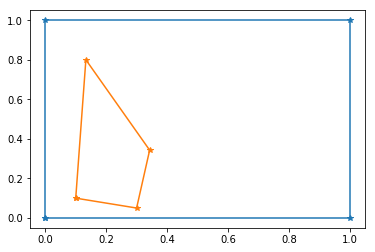

In [39]:
P_simple = np.array([[1, 0, 0.2], 
              [0, 1, 0.2],
              [2, -0.5, 2]])
P = P_simple
print(P)
p = P.dot(u_points)
p = p / p[2,:]
plt.plot(u_points[0,:], u_points[1,:], '*-');
plt.plot(p[0,:], p[1,:], '*-');

## Projective Transform from point correspondences

Here I am going to check if computing the transformation matrix from point correspondences gives the same projective matrix that I used to tranform unit square in a first place :)
For this we need to construct a system of equation from which we would want to find a matrix:
We start from
$$
\begin{bmatrix} x'\\ y'\\ 1 \end{bmatrix} = 
\begin{pmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} 
\end{pmatrix}
\begin{bmatrix} x \\ y\\ 1 \end{bmatrix}
$$
If we look a this from the perspective of the system of equation, then $x'$ can be found as:
$$
    x' = \frac{a_{11}x + a_{12}y + a_{13}}{a_{31}x + a_{32}y + a_{33}}
$$

Then for every point correspondence (x,y) <-> (x',y'), we would get 2 equations:
$$
    \begin{cases}
    a_{11}x + a_{12}y + a_{13} = x'xa_{31} + x'ya_{32} + x'a_{33} \\
     a_{21}x + a_{22}y + a_{23} = x'xa_{31} + x'ya_{32} + x'a_{33}
    \end{cases}
$$
Then rearranging everything  to one side would give
$$
    \begin{cases}
    a_{11}x + a_{12}y + a_{13} - x'xa_{31} - x'ya_{32} - x'a_{33} = 0 \\
    a_{21}x + a_{22}y + a_{23} - x'xa_{31} - x'ya_{32} - x'a_{33} = 0
    \end{cases}
$$
Every point correspondence gives us two equations and projective matrix has 8 degrees of freedom (...) so we would need at least 4 point correspondences to constraint this system.
If we stack them under each other and rewrite in matrix form, we will have the following system:
$$
\begin{bmatrix} 
x & y & 1 & 0 & 0 & 0 & -x'x & -x'y & -x' \\ 
0 & 0 & 0 & x & y & 1 & -y'x & -y'y & -y' 
\end{bmatrix}
\begin{bmatrix} a_{11} \\ a_{12} \\a_{13} \\a_{21} \\ ... \\ a_{33}
\end{bmatrix} 
= 0
$$
This is a homogeneous system of equations of the form $Xa = 0$, where we need to find $a$, don't confuse with $x$.
If in doubt about how to solve this, check my other notebook [system_of_equations](https://github.com/ovysotska/in_simple_english/blob/master/system_of_linear_equations.ipynb).

We are solving it here by using SVD. 

And btw, this matrix we find is called a **homography**. A transformation matrix that maps one set of points to another.

Projective [[ 1.   0.   0.2]
 [ 0.   1.   0.2]
 [ 2.  -0.5  2. ]]
Homography [[ 3.11135696e-01 -1.26820427e-16  6.22271391e-02]
 [-5.64799045e-17  3.11135696e-01  6.22271391e-02]
 [ 6.22271391e-01 -1.55567848e-01  6.22271391e-01]]


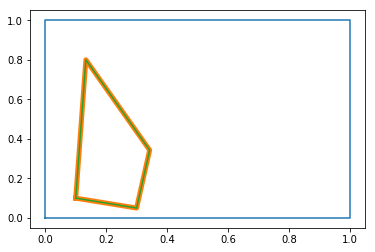

In [40]:
# computing A matrix 

def computeHomography(x, p):
    up = u_points
    
    D = np.array([], dtype=np.int64).reshape(0,9) # design matrix

    ## p = H*x

    for col in range(up.shape[1] - 1): 
        tmp = np.array([
            [x[0,col], x[1,col],1,0,0,0, -p[0,col]*x[0,col], -p[0,col]*x[1,col], -p[0,col]],
            [0,0,0, x[0,col], x[1,col], 1,-p[1,col]*x[0,col], -p[1,col]*x[1,col], -p[1,col]]
        ])
        D = np.vstack([D, tmp])

    # solving Dx = 0 to find x -> closest non trivial solution, since we have underdetermined system(?) 
    [U, S, Vt] = np.linalg.svd(D)
    H = Vt[-1].reshape(3, 3)
    return H


H = computeHomography(u_points, p)

p_h = H.dot(u_points)
p_h = p_h / p_h[2,:]

plt.plot(u_points[0,:], u_points[1,:]);
plt.plot(p[0,:], p[1,:], linewidth = 5);
plt.plot(p_h[0,:], p_h[1,:]);

# even though the values of P and H are not the same, they should be the same up to a scale
print("Projective", P)
print("Homography", H)
 
# We can see, in the plots, that the matrices lead to the same tranformation  

TODO: Do with using Kronecker product


# Image rectification

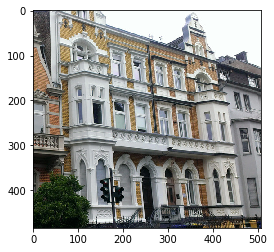

In [41]:
import cv2
img = cv2.imread("data/building/building_small.jpg") # reads dats as BGR
# this step is unnecessary, i just like it to be in original color
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # transforming to RGB
plt.imshow(img);

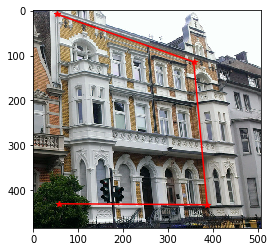

In [42]:
img_points = np.array([[8, 114, 432, 430],
                       [52, 357, 387, 57], 
                       [1,1,1,1]])
plt.figure(1)
plt.clf;
plt.imshow(img);
plt.plot(img_points[1,:], img_points[0,:], 'r*-')


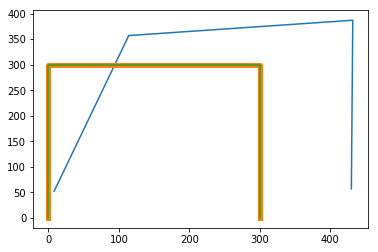

In [43]:
pp = np.array([[0, 0, 300, 300],
               [0, 300, 300, 0], 
               [1,1,1,1]])
H_img = computeHomography(img_points, pp)

rect_points = H_img.dot(img_points)
rect_points = rect_points / rect_points[2,:]

plt.plot(img_points[0,:], img_points[1,:]);
plt.plot(rect_points[0,:], rect_points[1,:], linewidth = 5);
plt.plot(pp[0,:], pp[1,:]);

In [44]:
# Copy the color values
inv_H = np.linalg.inv(H_img)
rect_img = np.zeros((300, 300, 3), np.uint8)
for r in range(300):
    for c in range(300):
        orig_p = inv_H.dot(np.array([r,c,1]))
        o_r = int(round(orig_p[0] / orig_p[2]))
        o_c = int(round(orig_p[1] / orig_p[2]))
        # check if valid TODO check border conditions of the pixels
        rect_img[r, c, :] = img[o_r, o_c, :]

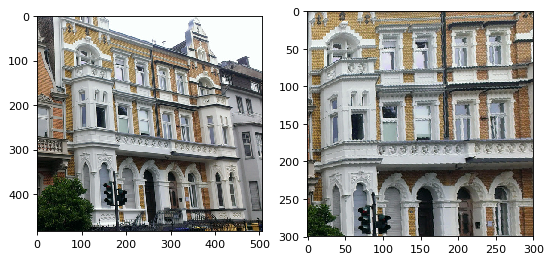

In [45]:
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(img);

plt.subplot(122)
plt.imshow(rect_img);
